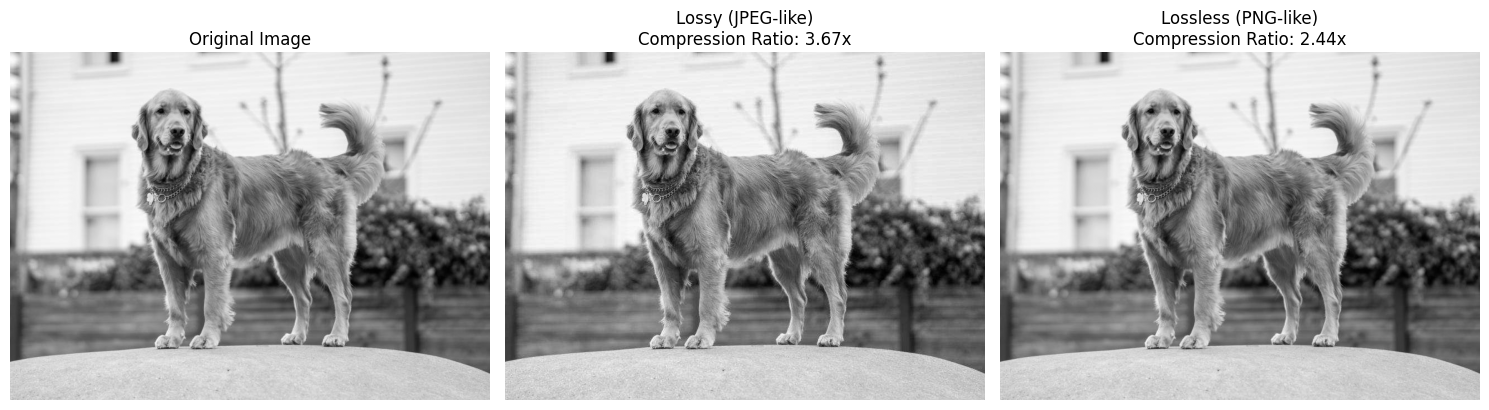

Lossy Compression Ratio: 3.67x
Lossless Compression Ratio: 2.44x


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

# Function to perform block-wise DCT
def blockwise_dct(image, block_size=8):
    """Applies DCT block-wise to an image."""
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)

    # Process the image in block sizes
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            # Apply DCT to the block
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image

# Function to perform block-wise Inverse DCT
def blockwise_idct(dct_image, block_size=8):
    """Applies Inverse DCT block-wise to an image."""
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)

    # Process the DCT image in block sizes
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            # Apply Inverse DCT to the block
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block

    return image_reconstructed

# Function to apply quantization to the DCT coefficients (block-wise)
def blockwise_quantize_dct(dct_image, quant_matrix, block_size=8):
    """Quantizes the DCT coefficients block-wise."""
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i + block_size, j:j + block_size]
            quantized_block = np.round(block / quant_matrix)  # Quantization
            quantized_dct[i:i + block_size, j:j + block_size] = quantized_block

    return quantized_dct

# Function to dequantize the DCT coefficients (block-wise)
def blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size=8):
    """Dequantizes the DCT coefficients block-wise."""
    h, w = quantized_dct.shape
    dequantized_dct = np.zeros_like(quantized_dct)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct[i:i + block_size, j:j + block_size]
            dequantized_block = block * quant_matrix  # Dequantization
            dequantized_dct[i:i + block_size, j:j + block_size] = dequantized_block

    return dequantized_dct

# Function to perform lossy compression (JPEG-like)
def lossy_compression(image, quality=50, block_size=8):
    """
    Perform JPEG-like lossy compression using DCT and quantization.

    Parameters:
    - image: Input grayscale image
    - quality: Compression quality (0-100, lower means more compression)
    - block_size: Size of the blocks for DCT (usually 8x8)

    Returns:
    - compressed_image: Reconstructed image after compression
    - compression_ratio: Ratio of original size to compressed size
    """
    # Make a copy of the image
    img = image.copy()

    # Pad the image to make its dimensions a multiple of block_size
    h, w = img.shape
    new_h = ((h + block_size - 1) // block_size) * block_size
    new_w = ((w + block_size - 1) // block_size) * block_size
    padded_image = cv2.copyMakeBorder(img, 0, new_h - h, 0, new_w - w,
                                      cv2.BORDER_CONSTANT, value=0)

    # Define standard JPEG quantization matrix
    base_quant_matrix = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])

    # Adjust quantization matrix based on quality
    if quality < 50:
        scale = 5000 / quality
    else:
        scale = 200 - 2 * quality

    quant_matrix = np.floor((base_quant_matrix * scale + 50) / 100)
    quant_matrix = np.clip(quant_matrix, 1, 255).astype(np.float32)

    # Apply block-wise DCT
    dct_image = blockwise_dct(padded_image, block_size)

    # Quantize the DCT coefficients
    quantized_dct = blockwise_quantize_dct(dct_image, quant_matrix, block_size)

    # Calculate size of quantized data (approximation)
    original_size = padded_image.size * padded_image.itemsize
    compressed_size = np.count_nonzero(quantized_dct) * 2  # Assuming 2 bytes per non-zero value

    # Dequantize to get the approximate DCT coefficients
    dequantized_dct = blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size)

    # Reconstruct the image using block-wise IDCT
    image_reconstructed = blockwise_idct(dequantized_dct, block_size)

    # Crop back to original size
    image_reconstructed = image_reconstructed[:h, :w]

    # Clip values to be in the 8-bit range and convert to uint8
    image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

    # Calculate compression ratio
    if compressed_size > 0:
        compression_ratio = original_size / compressed_size
    else:
        compression_ratio = float('inf')

    return image_reconstructed, compression_ratio

# Function to perform lossless compression (PNG-like)
def lossless_compression(image):
    """
    Perform lossless compression similar to PNG.

    Parameters:
    - image: Input grayscale image

    Returns:
    - compressed_image: Same as input (no quality loss)
    - compression_ratio: Ratio of original size to compressed size
    """
    # Convert image to PIL Image
    pil_img = Image.fromarray(image)

    # Save image to PNG in-memory
    buffer = io.BytesIO()
    pil_img.save(buffer, format="PNG")

    # Get the size of the compressed image
    compressed_size = buffer.tell()

    # Calculate original size
    original_size = image.size * image.itemsize

    # Calculate compression ratio
    compression_ratio = original_size / compressed_size

    # For lossless compression, the output image is identical to the input
    return image, compression_ratio

# Function to display comparison
def display_compression_comparison(original, lossy, lossless, lossy_ratio, lossless_ratio):
    """Display original image alongside compressed versions with metrics."""
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot lossy compressed image
    plt.subplot(1, 3, 2)
    plt.imshow(lossy, cmap='gray')
    plt.title(f'Lossy (JPEG-like)\nCompression Ratio: {lossy_ratio:.2f}x')
    plt.axis('off')

    # Plot lossless compressed image
    plt.subplot(1, 3, 3)
    plt.imshow(lossless, cmap='gray')
    plt.title(f'Lossless (PNG-like)\nCompression Ratio: {lossless_ratio:.2f}x')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Main function to demonstrate both compression methods
def main(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Perform lossy compression (JPEG-like)
    lossy_image, lossy_ratio = lossy_compression(image, quality=50)

    # Perform lossless compression (PNG-like)
    lossless_image, lossless_ratio = lossless_compression(image)

    # Display the results
    display_compression_comparison(image, lossy_image, lossless_image, lossy_ratio, lossless_ratio)

    # Print compression statistics
    print(f"Lossy Compression Ratio: {lossy_ratio:.2f}x")
    print(f"Lossless Compression Ratio: {lossless_ratio:.2f}x")

# Usage example
if __name__ == "__main__":
    # Replace with your image path
    image_path = "/content/dog image.jpeg"
    main(image_path)

PART-2

In [ ]:
#Loading Libraries
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
from PIL import Image
import io
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape for CNN (28x28x1)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define CNN model
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=64)

# Evaluate model
y_pred = np.argmax(model.predict(x_test), axis=1)

# Classification report


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8883 - loss: 0.3654 - val_accuracy: 0.9865 - val_loss: 0.0437
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9851 - loss: 0.0479 - val_accuracy: 0.9875 - val_loss: 0.0381
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9901 - loss: 0.0344 - val_accuracy: 0.9896 - val_loss: 0.0316
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9928 - loss: 0.0239 - val_accuracy: 0.9892 - val_loss: 0.0324
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9945 - loss: 0.0170 - val_accuracy: 0.9891 - val_loss: 0.0320
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9957 - loss: 0.0129 - val_accuracy: 0.9925 - val_loss: 0.0269
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9969 - loss: 0.0101 - val_accuracy: 0.9903 - val_loss: 0.0284
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9963 - loss: 0.0097 - val_accuracy: 0

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion Matrix:
 [[ 977    0    0    0    0    0    0    2    1    0]
 [   0 1134    0    0    0    0    1    0    0    0]
 [   1    1 1025    0    0    0    0    3    2    0]
 [   0    0    1 1006    0    2    0    0    1    0]
 [   0    

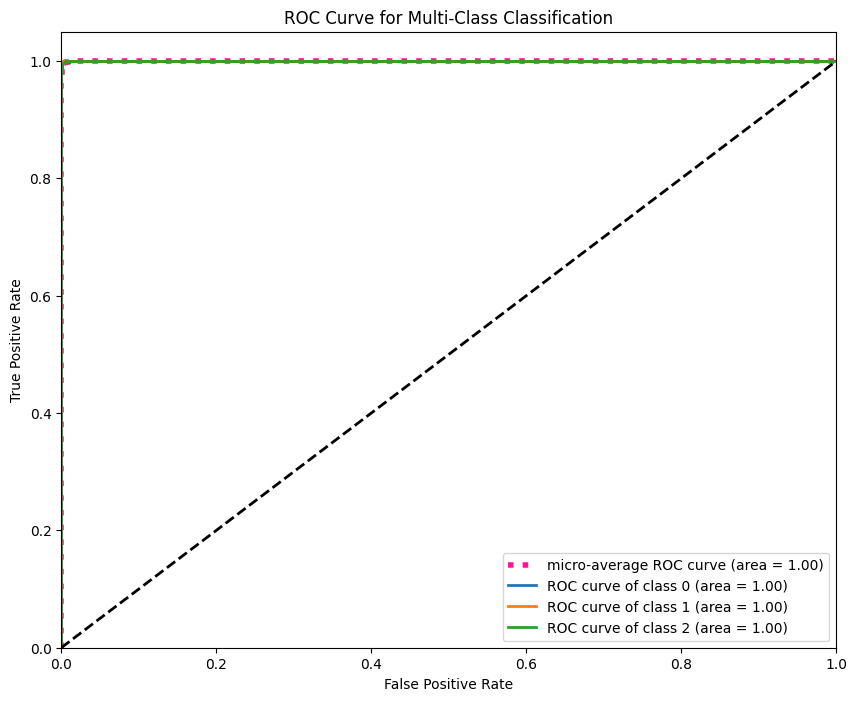

Class 0: AUC = 1.00
Class 1: AUC = 1.00
Class 2: AUC = 1.00
Class 3: AUC = 1.00
Class 4: AUC = 1.00
Class 5: AUC = 1.00
Class 6: AUC = 1.00
Class 7: AUC = 1.00
Class 8: AUC = 1.00
Class 9: AUC = 1.00
Micro-average AUC: 1.00


In [ ]:
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Get model probabilities
y_score = model.predict(x_test)

# Binarize true labels (assumes classes 0-9; adjust n_classes if needed)
n_classes = 10
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC for individual classes (optional: here, classes 0, 1, 2 are shown)
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

# Print AUC for all classes
for i in range(n_classes):
    print("Class {}: AUC = {:.2f}".format(i, roc_auc[i]))
print("Micro-average AUC: {:.2f}".format(roc_auc["micro"]))

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Define CNN model
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=64)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 78s 97ms/step - accuracy: 0.3274 - loss: 1.8187 - val_accuracy: 0.5222 - val_loss: 1.3266
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.5451 - loss: 1.2671 - val_accuracy: 0.5971 - val_loss: 1.1272
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.6263 - loss: 1.0627 - val_accuracy: 0.6234 - val_loss: 1.0491
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.6650 - loss: 0.9524 - val_accuracy: 0.6408 - val_loss: 1.0369
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.7059 - loss: 0.8433 - val_accuracy: 0.6822 - val_loss: 0.9177
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.7282 - loss: 0.7733 - val_accuracy: 0.7011 - val_loss: 0.8729
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.7553 - loss: 0.7012 - val_accuracy: 0.6929 - val_loss: 0.9011
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.7740 - loss: 0.6440 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1000
           1       0.87      0.78      0.83      1000
           2       0.73      0.47      0.58      1000
           3       0.52      0.49      0.50      1000
           4       0.65      0.70      0.67      1000
           5       0.52      0.73      0.61      1000
           6       0.82      0.75      0.79      1000
           7       0.76      0.74      0.75      1000
           8       0.78      0.85      0.82      1000
           9       0.76      0.82      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

Confusion Matrix:
 [[750  19  28  23  24  22   6   7  86  35]
 [ 24 783   2  20   4   7  11  11  34 104]
 [ 71   5 475  96 100 131  49  38  25  10]
 [ 18   6  41 491  64 269  39  37  12  23]
 [ 18   

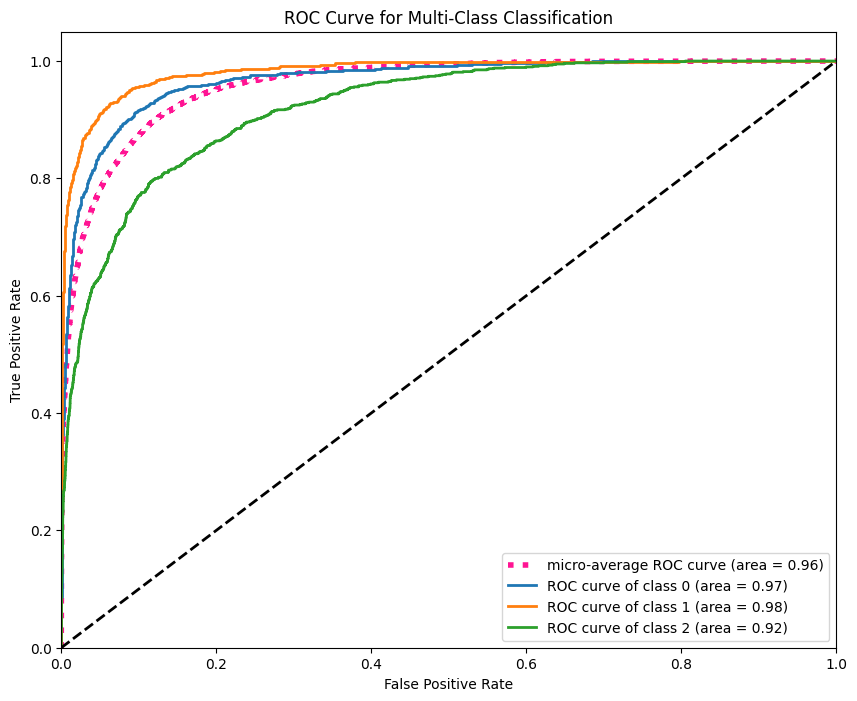

Class 0: AUC = 0.97
Class 1: AUC = 0.98
Class 2: AUC = 0.92
Class 3: AUC = 0.91
Class 4: AUC = 0.95
Class 5: AUC = 0.94
Class 6: AUC = 0.97
Class 7: AUC = 0.97
Class 8: AUC = 0.98
Class 9: AUC = 0.98
Micro-average AUC: 0.96


In [ ]:
# Evaluate model
y_pred = np.argmax(model.predict(x_test), axis=1)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Get model probabilities
y_score = model.predict(x_test)

# Binarize true labels (assumes classes 0-9; adjust n_classes if needed)
n_classes = 10
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC for individual classes (optional: here, classes 0, 1, 2 are shown)
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

# Print AUC for all classes
for i in range(n_classes):
    print("Class {}: AUC = {:.2f}".format(i, roc_auc[i]))
print("Micro-average AUC: {:.2f}".format(roc_auc["micro"]))